In [1]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, BooleanType

#other needed packages
import re
import os

# Set JAVA_HOME for PySpark
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17'

spark = SparkSession.builder \
    .appName("stock market preds") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/18 02:51:01 WARN Utils: Your hostname, Jeffreys-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.17 instead (on interface en0)
26/01/18 02:51:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/18 02:51:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/18 02:51:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# functions to import data, run SQL from file and save back to file
# function to import and clean columns
def import_csv_to_table(table_name, file, format_cols):

    #read source files
    df = spark.read.csv(file, header=True, quote="\"",
                        escape="\"", multiLine=True, inferSchema=True)

    #clean column names
    if format_cols:
        cols_formatted = [re.sub(r"[^a-zA-Z0-9\s]", "", col_name).lower().replace(" ", "_") for col_name in df.columns]
        df = df.toDF(*cols_formatted)

    # create SQL view
    df.createOrReplaceTempView(f"{table_name}")
    return df

#run a SQL step
def sql_step(file):
    with open(file, 'r', encoding='utf-8') as file:
        sql_text = file.read()
    results = spark.sql(sql_text)
    return results

#run SQL and view output inline
def run_sql(file, rowstoshow, print_sql):
    with open(file, 'r', encoding='utf-8') as file:
        sql_text = file.read()
    results = spark.sql(sql_text)
    if print_sql == True: print(sql_text)
    results.show(rowstoshow, truncate=False)

# export data frame to csv
def export_csv(df, output_dir, final_file_name):
    df.coalesce(1).write.csv(output_dir, header=True, mode="overwrite")
    for file in os.listdir(output_dir):
        if file.startswith("part-") and file.endswith(".csv"):
            part_file_path = os.path.join(output_dir, file)
            break
    if part_file_path:
        os.rename(part_file_path, os.path.join(output_dir, final_file_name))
        print(f"CSV saved as: {final_file_name}")
    else:
        print("Error: Part file not found.")

In [3]:
news = import_csv_to_table("news", "raw_data/news_data.csv", False)
stocks = import_csv_to_table("stocks", "raw_data/stock_data.csv", False)

In [4]:
feature_set = sql_step("sql/sentiment_data_prep_v2.sql")
feature_set.show(30, truncate=False)

+---------------+------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+
|news_article_id|symbol|news_date |article_text                                                                                                                                                                                                                                                                                                                                                            |percent_daily_price_change|
+---------------+------+----------+---------------------------------------------------------------------------------------------------------------------

In [5]:
# Setup PyTorch with MPS
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [6]:
# load finBERT and tokenizer
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModel.from_pretrained("ProsusAI/finbert").to(device)


/Users/jeffreyvananderson/Library/CloudStorage/OneDrive-Personal/stock_market_preds_v1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Score sentiment with FinBERT
from transformers import AutoModelForSequenceClassification
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

# Load classifier and convert to pandas
finbert_classifier = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device).eval()
labels = ['positive', 'negative', 'neutral']
df = feature_set.toPandas()

# Score each article with progress bar
sentiments, confidences = [], []
for text in tqdm(df['article_text'], desc="Scoring sentiment"):
    inputs = tokenizer(text[:512], return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        probs = F.softmax(finbert_classifier(**inputs).logits, dim=-1)[0]
    sentiments.append(labels[probs.argmax()])
    confidences.append(probs.max().item())

df['sentiment'], df['confidence'] = sentiments, confidences
print(f"\nSentiment distribution:\n{df['sentiment'].value_counts()}\n")
df[['symbol', 'news_date', 'sentiment', 'confidence', 'percent_daily_price_change']].head(10)

Scoring sentiment: 100%|██████████| 35430/35430 [07:07<00:00, 82.89it/s] 



Sentiment distribution:
sentiment
neutral     22024
positive     7826
negative     5580
Name: count, dtype: int64



,symbol,news_date,sentiment,confidence,percent_daily_price_change
0,LII,2025-10-22,neutral,0.870539,-0.013263
1,SF,2025-10-22,neutral,0.870539,-0.000508
2,VRT,2025-11-18,neutral,0.867198,-0.097841
3,AAON,2025-08-12,positive,0.943655,-0.041960
4,TSLA,2026-01-05,neutral,0.942365,-0.010301
5,GS,2025-10-14,neutral,0.871837,-0.016311
6,ADC,2025-11-24,neutral,0.922906,0.001867
7,NDAQ,2025-10-21,negative,0.802842,0.012194
8,ZS,2025-12-01,neutral,0.893835,0.012171
9,CRUS,2025-11-04,neutral,0.874435,-0.011582


In [9]:
df.head()

,news_article_id,symbol,news_date,article_text,percent_daily_price_change,sentiment,confidence
0,48346820,LII,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.013263,neutral,0.870539
1,48346820,SF,2025-10-22,"Headline: Earnings Scheduled For October 22, 2...",-0.000508,neutral,0.870539
2,48931230,VRT,2025-11-18,Headline: 10 Industrials Stocks With Whale Ale...,-0.097841,neutral,0.867198
3,47070626,AAON,2025-08-12,Headline: Mercury Systems Posts Better-Than-Ex...,-0.041960,positive,0.943655
4,49699047,TSLA,2026-01-05,Headline: EXCLUSIVE: Top 20 Most-Searched Tick...,-0.010301,neutral,0.942365


In [10]:
os.makedirs("processed_data", exist_ok=True)
df.to_csv("processed_data/finbert_news_classifications.csv", index=False)
print(f"Exported {len(df)} rows to processed_data/finbert_news_classifications.csv")

Exported 35430 rows to processed_data/finbert_news_classifications.csv


/var/folders/mt/dv_d_3bn46b5lgf_6ht76tkr0000gn/T/ipykernel_3773/3179260100.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot([df[df['sentiment']==s]['percent_daily_price_change']*100 for s in ['positive','neutral','negative']],


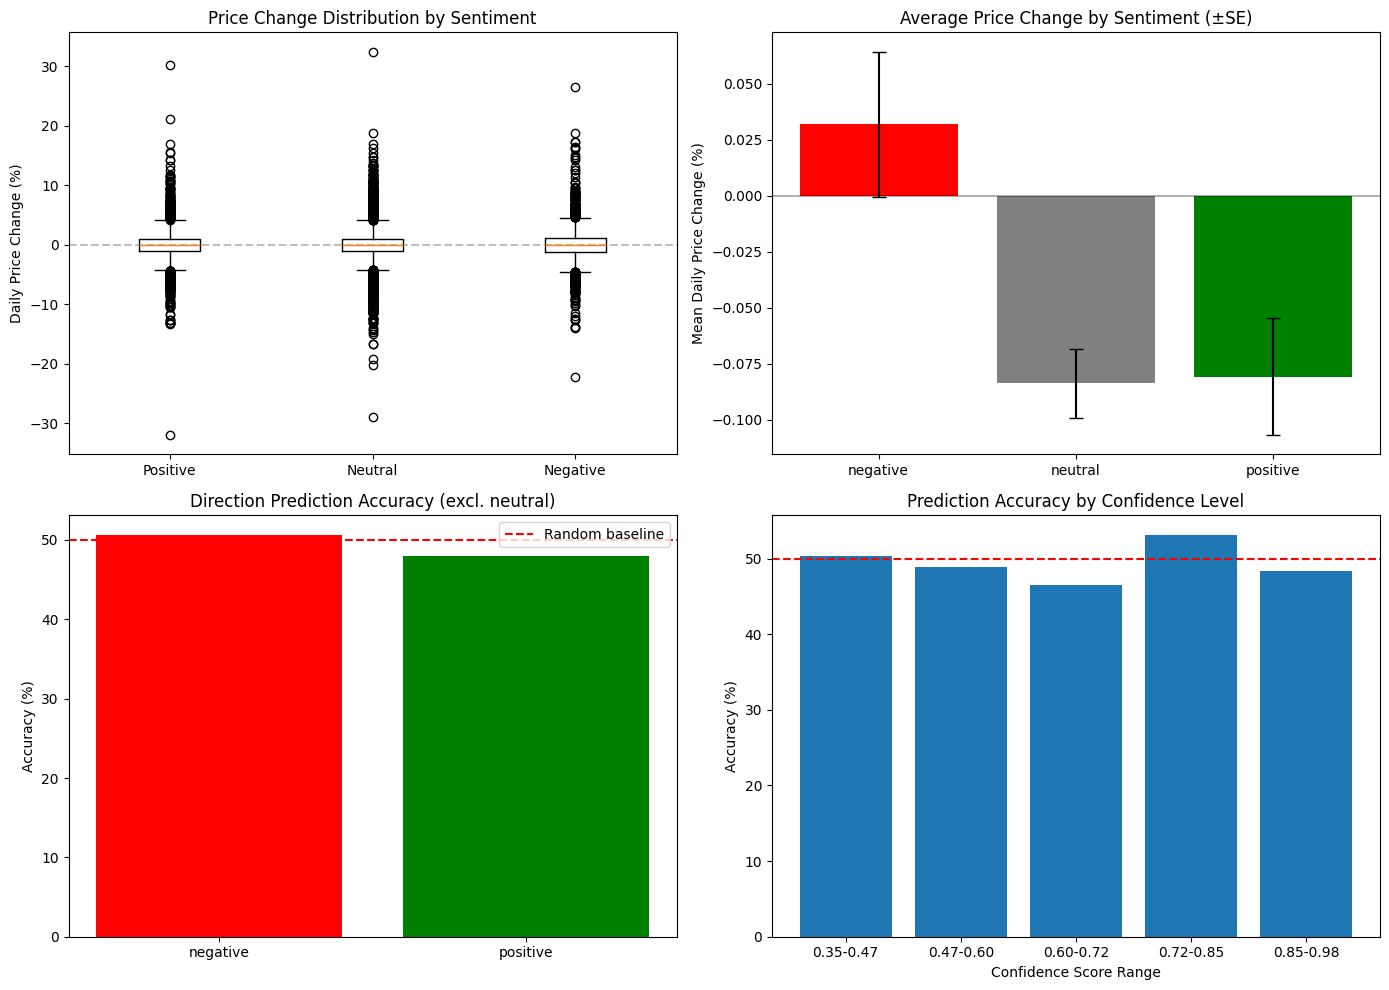

SENTIMENT CORRELATION SUMMARY

Mean price change by sentiment:
  positive  : -0.081%
  neutral   : -0.084%
  negative  : +0.032%

Overall direction accuracy (pos/neg only): 49.1%
High confidence (>0.9) accuracy: 48.3%


In [11]:
# Sentiment vs Price Change Analysis
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Box plot: Price change by sentiment
axes[0,0].boxplot([df[df['sentiment']==s]['percent_daily_price_change']*100 for s in ['positive','neutral','negative']], 
                   labels=['Positive','Neutral','Negative'])
axes[0,0].set_ylabel('Daily Price Change (%)')
axes[0,0].set_title('Price Change Distribution by Sentiment')
axes[0,0].axhline(0, color='gray', linestyle='--', alpha=0.5)

# 2. Mean price change by sentiment with error bars
means = df.groupby('sentiment')['percent_daily_price_change'].agg(['mean','std','count'])
colors = {'positive':'green', 'neutral':'gray', 'negative':'red'}
bars = axes[0,1].bar(means.index, means['mean']*100, yerr=means['std']*100/np.sqrt(means['count']), 
                      color=[colors[s] for s in means.index], capsize=5)
axes[0,1].set_ylabel('Mean Daily Price Change (%)')
axes[0,1].set_title('Average Price Change by Sentiment (±SE)')
axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.3)

# 3. Actual direction accuracy
df['actual_direction'] = df['percent_daily_price_change'].apply(lambda x: 'positive' if x > 0 else 'negative')
df['correct'] = ((df['sentiment']=='positive') & (df['actual_direction']=='positive')) | \
                ((df['sentiment']=='negative') & (df['actual_direction']=='negative'))
acc_by_sent = df[df['sentiment']!='neutral'].groupby('sentiment')['correct'].mean()
axes[1,0].bar(acc_by_sent.index, acc_by_sent*100, color=[colors[s] for s in acc_by_sent.index])
axes[1,0].set_ylabel('Accuracy (%)')
axes[1,0].set_title('Direction Prediction Accuracy (excl. neutral)')
axes[1,0].axhline(50, color='red', linestyle='--', label='Random baseline')
axes[1,0].legend()

# 4. Confidence vs accuracy scatter
df['abs_change'] = df['percent_daily_price_change'].abs()
conf_bins = pd.cut(df['confidence'], bins=5)
conf_acc = df[df['sentiment']!='neutral'].groupby(conf_bins, observed=True)['correct'].mean()
axes[1,1].bar(range(len(conf_acc)), conf_acc*100, tick_label=[f'{i.left:.2f}-{i.right:.2f}' for i in conf_acc.index])
axes[1,1].set_xlabel('Confidence Score Range')
axes[1,1].set_ylabel('Accuracy (%)')
axes[1,1].set_title('Prediction Accuracy by Confidence Level')
axes[1,1].axhline(50, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Summary stats
print("="*60)
print("SENTIMENT CORRELATION SUMMARY")
print("="*60)
print(f"\nMean price change by sentiment:")
for s in ['positive','neutral','negative']:
    m = df[df['sentiment']==s]['percent_daily_price_change'].mean()*100
    print(f"  {s:10}: {m:+.3f}%")
print(f"\nOverall direction accuracy (pos/neg only): {df[df['sentiment']!='neutral']['correct'].mean()*100:.1f}%")
print(f"High confidence (>0.9) accuracy: {df[(df['confidence']>0.9) & (df['sentiment']!='neutral')]['correct'].mean()*100:.1f}%")